In [1]:
from safetensors import safe_open
import torch

In [2]:
ls mla_ckpts/

layer00/  layer04/  layer08/  layer12/  layer16/  layer20/  layer24/
layer01/  layer05/  layer09/  layer13/  layer17/  layer21/  layer25/
layer02/  layer06/  layer10/  layer14/  layer18/  layer22/  layer26/
layer03/  layer07/  layer11/  layer15/  layer19/  layer23/


In [3]:
ls mla_ckpts/layer00

mla_ckpt_000.safetensors  mla_ckpt_004.safetensors  mla_ckpt_008.safetensors
mla_ckpt_001.safetensors  mla_ckpt_005.safetensors  mla_ckpt_009.safetensors
mla_ckpt_002.safetensors  mla_ckpt_006.safetensors  mla_ckpt_010.safetensors
mla_ckpt_003.safetensors  mla_ckpt_007.safetensors  mla_ckpt_011.safetensors


In [4]:
file_name = "mla_ckpts/layer18/mla_ckpt_010.safetensors"

tensors = {}
with safe_open(file_name, framework="pt", device=0) as f:
    for k in f.keys():
        tensors[k] = f.get_tensor(k)

In [5]:
for name, tensor in tensors.items():
    print(name, tensor.shape, tensor.dtype, tensor.device, sep=" | ")

kv_cache_used | torch.Size([3, 19, 512]) | torch.bfloat16 | cuda:0
output_x | torch.Size([3, 1, 16, 512]) | torch.bfloat16 | cuda:0
pe_cache_used | torch.Size([3, 19, 64]) | torch.bfloat16 | cuda:0
q_nope | torch.Size([3, 1, 16, 512]) | torch.bfloat16 | cuda:0
q_pe | torch.Size([3, 1, 16, 64]) | torch.bfloat16 | cuda:0
scores | torch.Size([3, 1, 16, 19]) | torch.bfloat16 | cuda:0
softmax_scale | torch.Size([]) | torch.bfloat16 | cuda:0


In [6]:
tensors["softmax_scale"]

tensor(0.1147, device='cuda:0', dtype=torch.bfloat16)

In [7]:
def verify_mla(tensors):
    q_nope = tensors["q_nope"]
    q_pe = tensors["q_pe"]
    kv_cache_used = tensors["kv_cache_used"]
    pe_cache_used = tensors["pe_cache_used"]
    softmax_scale = tensors["softmax_scale"]
    mask = tensors.get("mask")  # default to None
    
    scores = (torch.einsum("bshc,btc->bsht", q_nope, kv_cache_used) +
              torch.einsum("bshr,btr->bsht", q_pe, pe_cache_used)) * softmax_scale
              
    if mask is not None:
        scores += mask.unsqueeze(1)
    scores = scores.softmax(dim=-1, dtype=torch.float32).type_as(q_nope)
    
    x = torch.einsum("bsht,btc->bshc", scores, kv_cache_used)

    x_ref = tensors["output_x"]
    scores_ref = tensors["scores"]

    x_diff = torch.abs(x - x_ref)
    print(x_diff.max(), x_diff.mean())
    scores_diff = torch.abs(scores - scores_ref)
    print(scores_diff.max(), scores_diff.mean())
    
    return x, scores

In [8]:
x, scores = verify_mla(tensors)

tensor(0.0625, device='cuda:0', dtype=torch.bfloat16) tensor(0.0003, device='cuda:0', dtype=torch.bfloat16)
tensor(0.0078, device='cuda:0', dtype=torch.bfloat16) tensor(5.0068e-05, device='cuda:0', dtype=torch.bfloat16)


In [9]:
import matplotlib.pyplot as plt

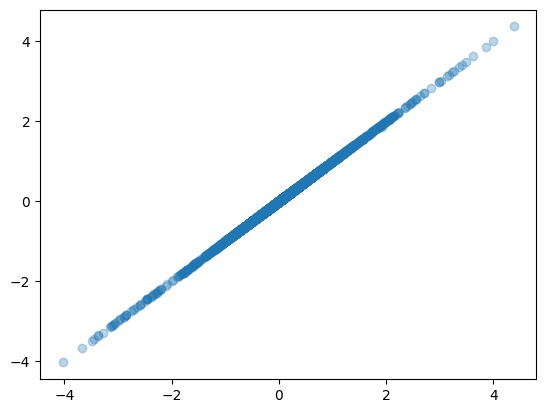

In [10]:
plt.scatter(
    x.cpu().to(torch.float32).numpy(),
    tensors["output_x"].cpu().to(torch.float32).numpy(),
    alpha=0.3
)

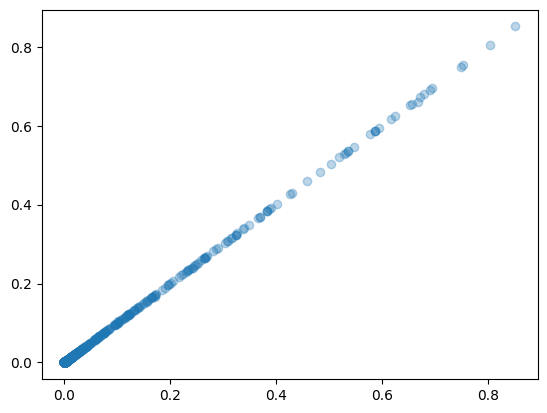

In [11]:
plt.scatter(
    scores.cpu().to(torch.float32).numpy(),
    tensors["scores"].cpu().to(torch.float32).numpy(),
    alpha=0.3
)